# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

In [1]:
import numpy as np
import pytest


def chamfer(queries: np.ndarray, vectors: np.ndarray):
        """Takes two sets of vectors and calculates chamfer
        
        O()
        """

        # (n, m) matrix of all the pairwise dot products
        dot_products = queries @ vectors.T

        # sum the max value for each query (row)
        chamfer = np.sum(np.max(dot_products, axis=1))
        return chamfer

# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert chamfer(A, B) == pytest.approx(1.0)
assert chamfer(B, A) == pytest.approx(1 + np.sqrt(.5))
assert chamfer(B, C) == pytest.approx(2)
assert chamfer(B, B) == pytest.approx(2)
assert chamfer(C, C) == pytest.approx(4)

In [2]:
import matplotlib.pyplot as plt
from shared.lsh_forest import LSHForest, MultiDocLSHForest, BitSamplingLSH

def plot(x, y, xlabel):
    plt.figure()
    plt.plot(x, y, marker='o')
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Similarity Score')
    plt.title(f'Convergence of LSH approximation as {xlabel} grows')
    plt.show()

def experiment(variable, values, defaults, build, best):
        sims, docs = [], []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(parameters['l'], parameters['k'], parameters['km'])
                sim, doc = best(forest, parameters['a'])
                sims.append(sim)
                docs.append(doc)
        print(f"Finished experiment: {variable}")
        return sims, docs


def simple_approximate_best(forests: list[LSHForest], a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for document, forest in enumerate(forests):
                for i, query in enumerate(queries):
                        idx = forest.query(query, a, dist=distance)[0][0]
                        matches[document, i] = forest.data[idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc

def multidoc_approximate_best(forest: MultiDocLSHForest, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


n = 1000                                 # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 15                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}

# Get normalized document and query vectors
vectors = rng.normal(size=(n, m, d)).astype(np.float32)
vectors /= np.linalg.norm(vectors, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

# Constructors for each forest type
def build_simple_lsh(l, k, km):
        single_doc_forests = [LSHForest(BitSamplingLSH(d), l, k, km) for _ in range(n)]
        for doc, forest in enumerate(single_doc_forests):
                forest.batch_insert(vectors[doc])
        return single_doc_forests


def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(BitSamplingLSH(d), l, k, km)
        multi_doc_forest.batch_insert(vectors)
        return multi_doc_forest

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(best)




(15.287652015686035, 63)


Finished experiment: l
Finished experiment: k
Finished experiment: km
Finished experiment: a


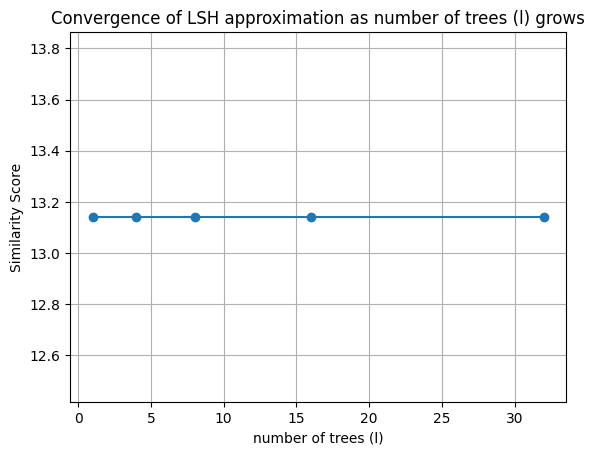

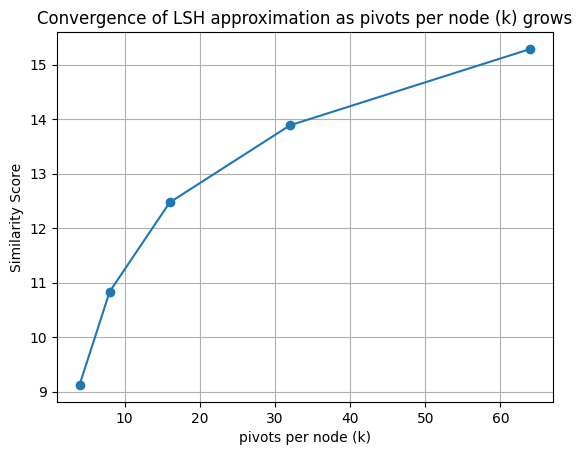

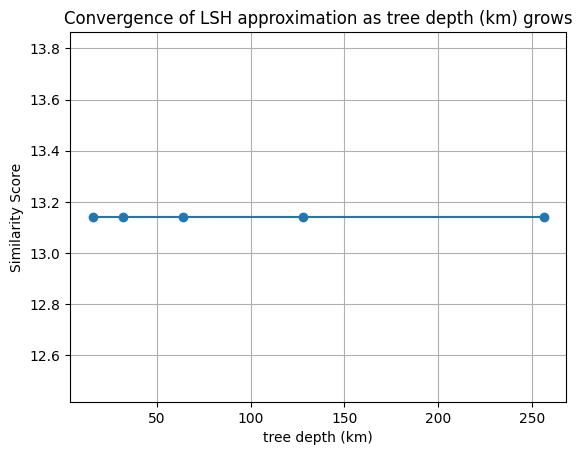

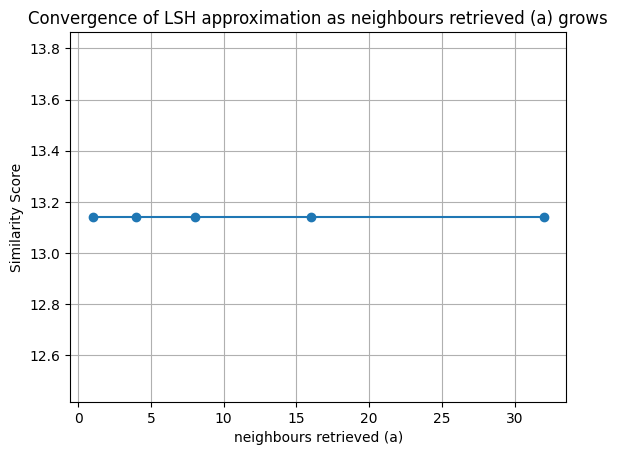

In [3]:

# Evaluate single-doc
results = {var: experiment(var, vals, defaults, build_simple_lsh, simple_approximate_best) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')


Finished experiment: l
Finished experiment: k
Finished experiment: km
Finished experiment: a


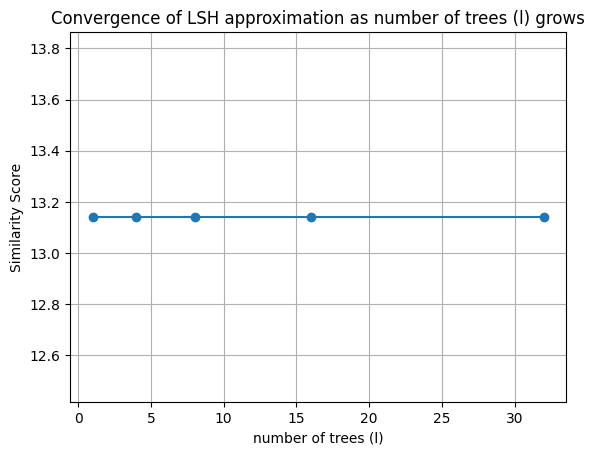

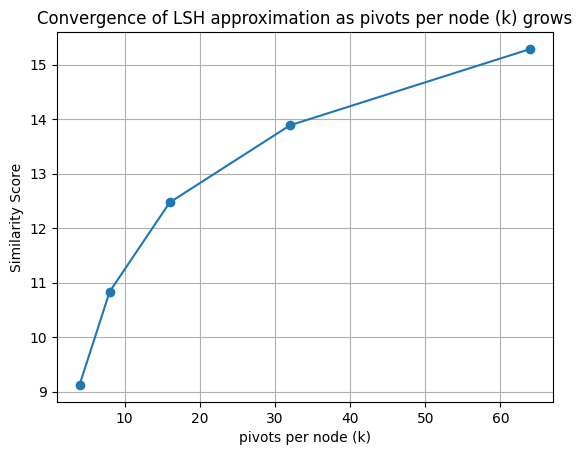

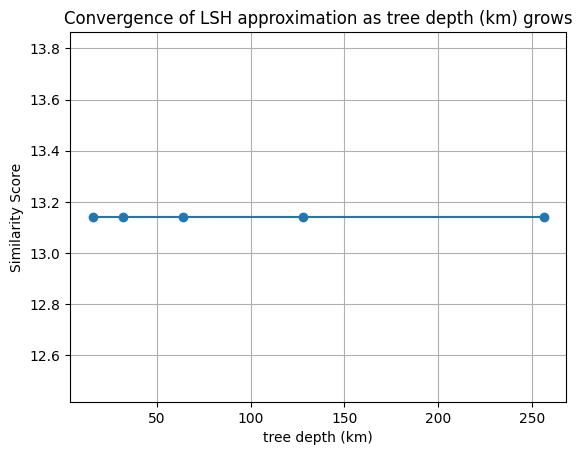

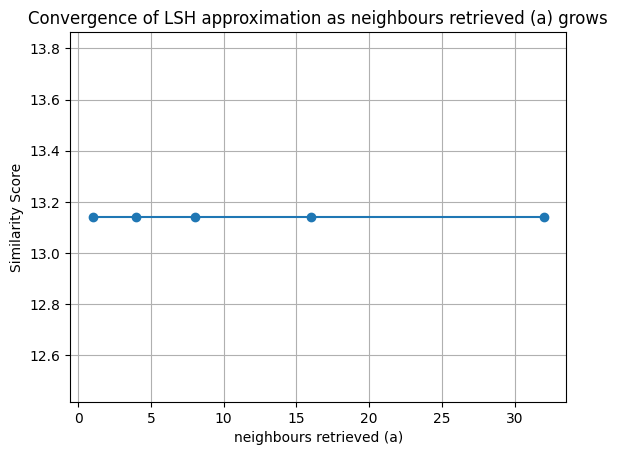

In [4]:

# Evaluate multi-doc
results = {var: experiment(var, vals, defaults, build_multidoc_lsh, multidoc_approximate_best) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')
